In [1]:
magma_dir = '/home/marco/epfl/magma/'

#### Init

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import textwrap

import random

## **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Output directory
OUTPUT_PATH = magma_dir+'summarization/compare_results/'

MODELS = {}

## **Function Definition**

In [4]:
def plot_compare_rouge(df_path_list, method_list, model_list, prf):
    df_list = []
    for df_path in df_path_list:
        df_list.append(pd.read_csv(df_path).set_index(['book', 'chapter']))
    
    num_df = len(df_list)
    
    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_df))

    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)

    xticks = 2*np.array(np.arange(1, len(config.ROUGE_TYPES)+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for df, m, model, var in\
        zip(df_list, method_list, model_list, np.linspace(-0.15*num_df, 0.15*num_df, num_df)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+prf+'_'+model].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=method_list[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Comparison '+prf, fontsize='xx-large')
    ax.set_ylabel(prf, fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Compare Results**

#### Para WordEmbed Base vs Fine-tune freezed vs Fine-tune Bullet by Bullet

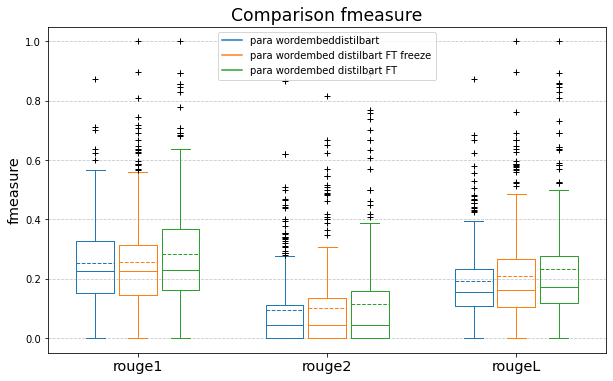

In [17]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?_bullet_by_bullet.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?_bullet_by_bullet.csv'],
    
    ['para wordembeddistilbart',
    'para wordembed distilbart FT freeze',
    'para wordembed distilbart FT'],
    
    ['sshleifer/distilbart-cnn-12-6',
    '/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    '/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/'],
    
    'fmeasure')

#### Para WordEmbed Base vs Fine-tune freezed vs Fine-tune

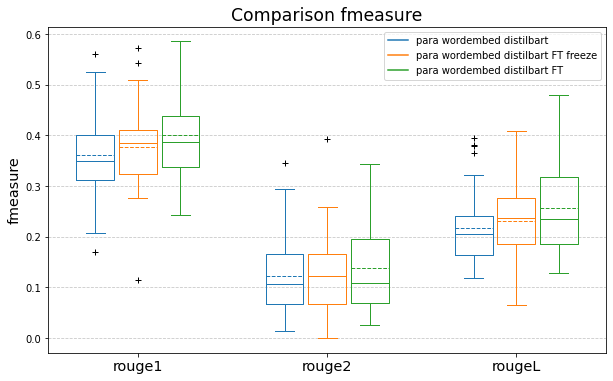

In [5]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/'+\
        'sshleifer?distilbart-cnn-12-6.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train?.csv',
    magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?.csv'],
    
    ['para wordembed distilbart',
    'para wordembed distilbart FT freeze',
    'para wordembed distilbart FT'],
    
    ['sshleifer/distilbart-cnn-12-6',
    '/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    '/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/'],
    
    'fmeasure')

#### Para WordEmbed Base vs Recurrent Decoder vs LED

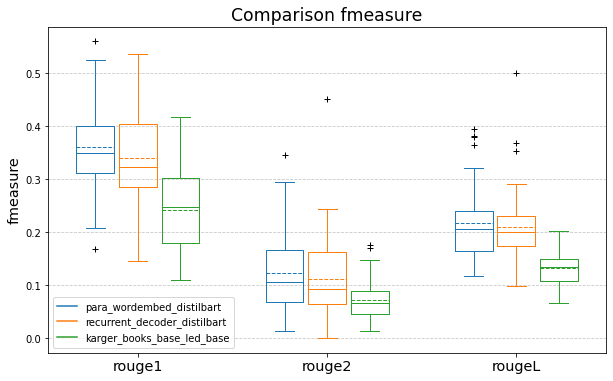

In [6]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/sshleifer?distilbart-cnn-12-6.csv',
    magma_dir+'summarization/recurrent_decoder_cc/bart/sshleifer?distilbart-cnn-12-6.csv',
    magma_dir+'summarization/karger_books_base/led/allenai?led-base-16384.csv'],
    ['para_wordembed_distilbart', 'recurrent_decoder_distilbart', 'karger_books_base_led_base'],
    ['sshleifer/distilbart-cnn-12-6', 'sshleifer/distilbart-cnn-12-6', 'allenai/led-base-16384'],
    'fmeasure')

#### Para WordEmbed FT vs LED FT

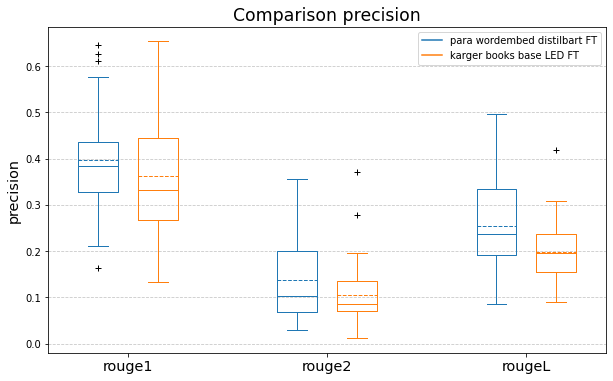

In [9]:
plot_compare_rouge(
    [magma_dir+'summarization/assign_bullets_para_wordembed/bart/?home?marco?epfl?magma?'+\
        'fine-tuning?sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train?.csv',
    magma_dir+'summarization/karger_books_base/led/'+\
        '?home?marco?epfl?magma?fine-tuning?allenai?led-base-16384_karger_books_base?checkpoint-60?.csv'],
    
    ['para wordembed distilbart FT',
    'karger books base LED FT'],
    
    [magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/',
    magma_dir+'fine-tuning/allenai?led-base-16384_karger_books_base/checkpoint-60/'],
    
    'precision')